$
\newcommand{\bu}{\mathbf{u}}
\newcommand{\bv}{\mathbf{v}}
\newcommand{\bw}{\mathbf{w}}
\newcommand{\bx}{\mathbf{x}}
\newcommand{\by}{\mathbf{y}}
\newcommand{\bz}{\mathbf{z}}
\newcommand{\bC}{\mathbf{C}}
\newcommand{\bD}{\mathbf{D}}
\newcommand{\bI}{\mathbf{I}}
\newcommand{\bU}{\mathbf{U}}
\newcommand{\bV}{\mathbf{V}}
\newcommand{\bW}{\mathbf{W}}
\newcommand{\bX}{\mathbf{X}}
\newcommand{\bY}{\mathbf{Y}}
\newcommand{\bSigma}{\mathbf{\Sigma}}
\newcommand{\bLambda}{\mathbf{\Lambda}}
\newcommand{\bbN}{\mathbb{N}}
\newcommand{\bbR}{\mathbb{R}}
\newcommand{\cU}{\mathcal{U}}
\newcommand{\rNN}{\mathrm{NN}}
$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Dimension reduction and clustering libraries
import umap
import hdbscan

import chart_studio as py
import plotly.graph_objs as go
import plotly.io as pio

axis_layout = dict(autorange=True, showgrid=False, zeroline=False, showline=False,
                   ticks='', showticklabels=False, title='', showbackground=False)
layout = dict(width=400, height=400, showlegend=False,
              margin=go.layout.Margin(l=0, r=0, b=0, t=0, pad=10),
              paper_bgcolor='rgba(0,0,0,0)', plot_bgcolor='rgba(0,0,0,0)',
              scene=dict(xaxis = axis_layout, yaxis=axis_layout, zaxis=axis_layout),
              scene_aspectmode='cube', scene_aspectratio=dict(x=1, y=1, z=1))

def cm_2_rgbstr(c):
    return f'rgb({int(round(c[0]*255))}, {int(round(c[1]*255))}, {int(round(c[2]*255))})'
def cma_2_rgbstr(c, a):
    return f'rgba({int(round(c[0]*255))}, {int(round(c[1]*255))}, {int(round(c[2]*255))}, {a})'

# PART 1: The curse of high dimensional data

Lets say we have $n$ data points, each containing $\large d$ attributes. Each data point we label $\large \bx_i$ with $\large i=1,\ldots,n$.

Each field could be an integer $(1,2,\ldots)$, a base pair $(A,C,G,T)$, or a real number $(\mathbb{R})$. For example, in single cell data we often have a vector of _reads_, which is a list of the number of times we have read a fragment, so a data point could look like

$$\large 
\bx_i = (12, 0, 39, 40, 1258, 0, 8, 39, \ldots, 27)
$$

This list has $d$ numbers in it.

In this talk, we assume each data point is a vector (list) of _real numbers_ of length $d$, that is 

$$ \large
\bx_i \in \bbR^d
$$

Yes, single cell datasets don't often look like this, and we are ignoring positivity and problems like _zero inflation_ that we typically see, but for our purposes it is simpler to consider Euclidian space.

We are interested in the fact that $\large d$ is very large (_typically in the thousands!_), meaning that our data is _high dimensional_. Such high dimensional data is difficult to process for (mathematically) very fundamental reasons.

For example, _clustering_ typically doesn't work directly on high dimensional data.

Throughout the rest of this workbook, we will write $\large \bX$ to denote the _data matrix_, that is the matrix of size $\large(n \times d)$ in which each data point $\bx_i$ (which is a vector of length $d$) is the $i$-th row of $\bX$, that is $\large[\bx_i]_j = \bX_{i,j}$.

### Consider $n$ uniformly distributed points in the unit cube $[0,1]^d$


Lets generate a data matrix where each component is independently and uniformly distributed in $\large[0,1]$, effectively meaning that each row of $\bX$ is a vector that is independently and uniformly distributed in $\large [0,1]^d$.

In [19]:
n = 1000
d = 3

# If we consider each column to be a data vector (i.e. x_i = X[:, i], then this
# generates n random points that are uniformly distributed in [0,1]^d
X = ___ # EXERCISE: FILL IN HERE
X = np.random.random((n,d))

# 1. In high dimensions all distances become the same

On most reasonable data sets $\large \{ \bx_i \}_{i=1}^n$, distances between all pairs of data points become very similar: 

$$
\large \max_{i \neq j} \| \bx_i - \bx_j \| \approx \min_{i \neq j} \| \bx_i - \bx_j \| \quad
\text{ as $d$ gets larger.}
$$

*(We use the notation $\| \bx \|$ to denote the length of the vector $\bx$)*

We can demonstrate this phenomenon with the uniformly distributed data we just generated:

In [12]:
# Calculate distances between each pair of points in the data set
dists = np.zeros((n,n))
for i in range(n):
    for j in range(i,n):
        #dists[i,j] = dists[j,i] = ___ # EXERCISE: FILL IN HERE
        dists[i,j] = dists[j,i] = np.linalg.norm(X[i] - X[j])

dists_max = dists.max()
dists_min = dists[np.triu_indices(n, k=1)].min()

print(f'{d} dimensions, {n} random points in [0,1]^{d}:')
print(f'max dist = {dists_max}, min dist = {dists_min}')
print('')

1000 dimensions, 1000 random points in [0,1]^1000:
max dist = 14.062901299351887, min dist = 11.773060034958208



# 2. In high dimensions all of the data lies on the edges

Consider the unit hypercube $\large [0,1]^d$. The mean of the uniform distribution $\large \cU([0,1]^d)$ on it is the centre point $\large (1/2,\ldots,1/2)$. But almost all the data will be nowhere near the mean! Why?

Lets consider the box $\large B = [1/4, 3/4]^d$. It surrounds the mean / centre point, it sits within $[0,1]^d$, and each side has length $1/2$. But what is the volume of this box?

$$
\large | B | = (1/2)^d
$$

which becomes _very small for large_ $d$! For example at $d = 10$ we have $\large | B | = (1/2)^{10} \approx 1/1000$. This means only _one in a thousand_ of our randomly generated points are likely to be in the box around the mean!

Even if we increased the sides of $B$ to $0.999$, eventually we get that $|B| \to 0$ for large enough $d$. So, most of the probability lies at the edges of the unit cube $[0,1]^d$

In [33]:
n = 1000
d = 10
X = np.random.random((n,d))

# Lets count the number of points in X that are "near the mean", by which we mean within the box [1/4, 3/4]^d
num_x_in_B = 0

for x in X:
    # This returns a vector of booleans
    #is_x_in_B = ___ # EXERCISE: FILL IN HERE
    is_x_in_B = (x > 1/4) & (x < 3/4)

    #print(x)
    #print(is_x_in_B)
    #print(np.all(is_x_in_B))
    
    if np.all(is_x_in_B):
        # Increment the count if ALL coordinates of this point within [1/4, 3/4]?
        num_x_in_B += 1
        
print(f'In dimension {d} there are {num_x_in_B} points out of {n} that are in B')

In dimension 10 there are 0 points out of 1000 that are in B


## This means everyone is an outlier in high dimensional statistics!

Lets consider a real world example, the _diabetes_ data set provided as part of ```sklearn```. It is a 10 dimensional data set, i.e. each data point has _10 attributes_.

 1. age in years
 2. sex
 3. bmi body mass index
 4. bp average blood pressure
 5. s1 tc, T-Cells (a type of white blood cells)
 6. s2 ldl, low-density lipoproteins
 7. s3 hdl, high-density lipoproteins
 8. s4 tch, thyroid stimulating hormone
 9. s5 ltg, lamotrigine
 10. s6 glu, blood sugar level
 
 Each field is recentered and scaled to be in the range $[-0.2, 0.2]$ with mean $0$.

Data shape: 442 by 10
Mean of each field: 
 [-3.63428493e-16  1.30834257e-16 -8.04534920e-16  1.28165452e-16
 -8.83531559e-17  1.32702421e-16 -4.57464634e-16  3.77730150e-16
 -3.83085422e-16 -3.41288202e-16]


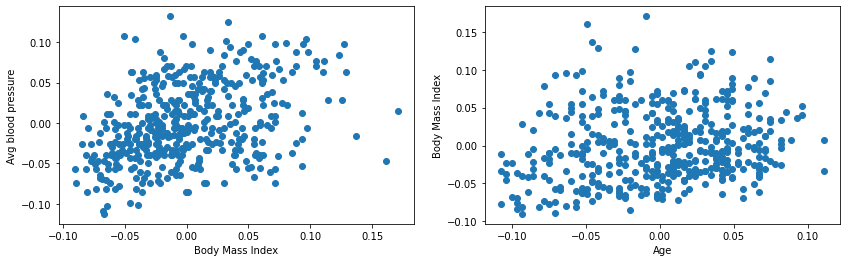

In [29]:
import sklearn.datasets
dia_data = sklearn.datasets.load_diabetes().data
n = dia_data.shape[0] # Number of samples
d = dia_data.shape[1] # Number of attributes (dimensionality)

print(f'Data shape: {n} by {d}')
print(f'Mean of each field: \n {dia_data.mean(axis=0)}')

fig, axs = plt.subplots(1, 2, figsize=(14, 4))
# Lets plot BMI vs blood pressure
axs[0].scatter(dia_data[:,2], dia_data[:,3])
axs[0].set_xlabel('Body Mass Index')
axs[0].set_ylabel('Avg blood pressure')

# Lets plot age vs BMI
axs[1].scatter(dia_data[:,0], dia_data[:,2])
axs[1].set_xlabel('Age')
axs[1].set_ylabel('Body Mass Index')
plt.show()

In [34]:
## Now lets find all the points that are within the restricted range of -0.05 to 0.05
#selection = ___ # EXERCISE: FILL IN HERE
selection = (dia_data > -0.05) & (dia_data < 0.05)

for i in range(d):
    
    num_selected = selection[:, i].sum()
    print(f'Number of samples with attribute {i} within [-0.05, 0.05]: {num_selected}')

    total_selection = np.all(selection[:,:i+1], axis=1)
    total_num_selected = total_selection.sum()
    print(f'Number of samples with all attributes up to {i} within [-0.05, 0.05]: {total_num_selected} \n')

Number of samples with attribute 0 within [-0.05, 0.05]: 303
Number of samples with all attributes up to 0 within [-0.05, 0.05]: 303 

Number of samples with attribute 1 within [-0.05, 0.05]: 235
Number of samples with all attributes up to 1 within [-0.05, 0.05]: 161 

Number of samples with attribute 2 within [-0.05, 0.05]: 307
Number of samples with all attributes up to 2 within [-0.05, 0.05]: 105 

Number of samples with attribute 3 within [-0.05, 0.05]: 298
Number of samples with all attributes up to 3 within [-0.05, 0.05]: 73 

Number of samples with attribute 4 within [-0.05, 0.05]: 324
Number of samples with all attributes up to 4 within [-0.05, 0.05]: 57 

Number of samples with attribute 5 within [-0.05, 0.05]: 325
Number of samples with all attributes up to 5 within [-0.05, 0.05]: 53 

Number of samples with attribute 6 within [-0.05, 0.05]: 319
Number of samples with all attributes up to 6 within [-0.05, 0.05]: 33 

Number of samples with attribute 7 within [-0.05, 0.05]: 34

# $k$-means fails in high dimension

Why? Lets inspect the algorithm. Remember, with $k$-means we specify the number of clusters $k$ as a parameter. 

1. Generate $k$ starting centroid points in $\mathbb{R}^d$, which we label $c_j$ for $j=1,\ldots,k$
2. For each data point $x_i$, find the centroid $c_j$ that is closest to it, and we now say $x_i$ is in cluster $j$
3. For each cluster $j$, we set the new centroid $c_j$ to be the average point of all $x_i$ in cluster $j$
4. Repeat from step 2 until the centroids $c_j$ stop moving.

The problem? In high dimensions, the distances $\| x_i - c_j \|$ are almost all the same (as we saw above), so the $x_i$ get attributed to arbitrary clusters, and the centroids $c_j$ do not converge to anything meaningful.

### Lets generate a really simple example

Lets consider $n$ points where the first attribute (or coordinate) is set to 0 for half the points, and 1 for the other half, and the rest of the attributes are independent and uniformly distributed in $[0,1]$

Our data matrix will look like

$
X = 
\begin{bmatrix}
0 & x_{1,2} & \cdots & x_{1,d} \\
0 & x_{2,2} & \cdots & x_{2,d} \\
\vdots & \vdots & & \vdots \\
0 & x_{n/2-1, 2} & \cdots & x_{n/2-1,d} \\
1 & x_{n/2, 2} & \cdots & x_{n/2,d} \\
1 & x_{n/2+1, 2} & \cdots & x_{n/2+1,d} \\
\vdots & \vdots &  & \vdots \\
1 & x_{n, 2} & \cdots & x_{n,d} \\
\end{bmatrix}
$

In [59]:
d = 10
n = 20

np.random.seed(0)
X = np.random.random((n, d))

# We set the first attribute to 0 for half the samples and 1 for the other half
#___ = 0 # EXERCISE: FILL IN HERE
#___ = 1 # EXERCISE: FILL IN HERE
X[:int(n/2), 0] = 0
X[int(n/2):, 0] = 1

from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2).fit(X)

print('What the labels "should" be: ')
print(X[:, 0].astype(np.int))
print('\nWhat k-means infers: ')
print(kmeans.labels_)

What the labels "should" be: 
[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1]

What k-means infers: 
[1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]


# So is there anything that can save us from this predicament?

### It could be that the data lives on some hidden structure or _manifold_

The data may actually be lying on some curved manifold embedded in the high dimensional space. Some natural questions arise:

 - Can we detect this underlying structure using the data somehow?
 - Can we then map the data to a lower dimensional space, but still retain the structure of the data?

This idea of mapping to a lower dimensional space is called _dimension reduction_. We want to reduce the dimensionality of data so that we can apply our statistical learning algorithms succesfully.

### An example of data that lives on an underlying _manifold_:

Lets consider an artificial example again. Lets say we have some data points that are distributed independently and uniformly on the unit square $[0,1]^2$. Now, lets say our observed data are points in 3 dimensions where the data points are the vectors $[x, y, f(x)]$, for some smooth function $f$. Consider the example in the following code. 

Rotate the 3d plot to see what's going on!

In [62]:
d = 3
n = 500

np.random.seed(0)
X = np.random.random((n, d))
X[:, 2] = np.sin(4 * np.pi * X[:, 0])

import matplotlib.cm
jet_colors = [ matplotlib.cm.jet(x) for x in X[:,0] ]
c_marker = dict(size=2.5, symbol='circle', color=jet_colors)

fig_data = [go.Scatter3d(x=X[:,0], y=X[:,1], z=X[:,2], mode='markers', marker=c_marker, showlegend=False)]

fig = go.Figure(data=fig_data, layout=layout)
camera = dict(eye=dict(x=2., y=0, z=0.))
fig.update_layout(scene_camera=camera)

fig.show()

# Dimension reduction through principal component analysis (PCA)

PCA is often used for dimension reduction. We perform an orthogonal projection on to the space of truncated principle components or _eigen-vectors_. It is a _linear_ method though, which can have its drawbacks.

How is it calculated?

Given our data points $\{x_i\}_{i=1}^n \subset \mathbb{R}^d$ or data matrix $\bX$, we take the mean $\mu$ and covariance matrix $\bC$ given by

$$\large
\begin{align} 
\mu &= \frac {1}{n} \sum_{i=1}^n x_i \\
%\bC_{i,j} &= \frac{1}{n-1} (x_i - \mu) \otimes ( x_j - \mu)
\bC &= \frac{1}{n-1} (\bX - \mu)^T (\bX - \mu)
\end{align}
$$

where $(\bX - \mu)$ is the matrix $\bX$ of size $n \times d$ with the vector $\mu$ of size $d$ subtracted from every row. Thus $\bC$ is a matrix of size $d \times d$.

The _principal components_ are given by the eigenvalues and eigenvectors of $\bC$, that is $\large \bC = \bV \bSigma \bV^T$, where $\bSigma$ is just the eigenvalues along the diagonal, and $\bV$ is an orthonormal matrix, the columns of which are the eigenvectors.

In [65]:
# Calculate the mean of the points and calculate the mean-free point set
#mean = ___ # EXERCISE: FILL IN HERE
#X_mf = ___ # EXERCISE: FILL IN HERE
mean = X.mean(axis=0)
X_mf = X - mean

# The covariance is calculated form the mean free points
#Cov = ___ # EXERCISE: FILL IN HERE
Cov = (X_mf.T @ X_mf) / (n-1)

# np.linalg.eigh calculates the eigen-decomposition for a Hermitian (i.e. symmetric) matrix
Sigma, V = np.linalg.eigh(Cov)

# Now we plot the PCA 
fig_pca = []
for sigma, v in zip(Sigma, V.T):
    fig_pca.append(go.Scatter3d(x=[mean[0], mean[0]+np.sqrt(sigma)*v[0]], 
                                y=[mean[1], mean[1]+np.sqrt(sigma)*v[1]],
                                z=[mean[2], mean[2]+np.sqrt(sigma)*v[2]],
                                mode='lines', line=dict(width=4, color='rgba(0,0,0,0.8)')))
    fig_pca.append(go.Scatter3d(x=[mean[0], mean[0]+v[0]], 
                                y=[mean[1], mean[1]+v[1]],
                                z=[mean[2], mean[2]+v[2]],
                                mode='lines', line=dict(width=1, dash='dash', color='rgba(0,0,0,0.8)')))

fig = go.Figure(data=fig_data+fig_pca, layout=layout)
fig.show()

### Now we project the data to the two largest principle componants, i.e. the two eigenvectors with largest eigenvalues

We know that $\large \bV$ is an orthonormal matrix, so for any data vector $\bx$, $\bV^T (\bx - \mu)$ will give us the data in the coordinates of the principal components.

If we take coordinates of the two biggest principle coordinates and multiply by the corresponding columns of $\bV$, we effectively get the data vector projected to the linear subspace of the two biggest principal components



In [67]:
# Now we translate all our data coordinates to PCA coordinates
X_pca = V.T @ X_mf.T

# We use the two largest principle components (which are the last two from the eigen-decomposition)
# This effectively calculates the projection.
X_proj = (np.outer(X_pca[1], V[:,1]) + np.outer(X_pca[2], V[:,2]) + mean).T

c_marker = dict(size=2.5, symbol='circle', color=jet_colors)
fig_proj = [go.Scatter3d(x=X_proj[0,:], y=X_proj[1,:], z=X_proj[2,:], mode='markers', marker=c_marker, showlegend=False)]

fig = go.Figure(data=fig_proj+fig_pca, layout=layout)
fig.show()

So what's the problem with applying PCA in this case? We can see from the colour of the points that dimension reduction through PCA has just _squashed_ the manifold in some direction.

This squashing is not the result we're looking for. For example, the red points and the light-blue points are all mixed up, but we can see from the original plot that we would ideally want to map the underlying sinusoid function.

# PART 2: Dimension reduction through _manifold learning_

We want something that can sense the _underlying manifold_ that the points sit upon. In a sense, knowing how the points are connected to each other is equivalent information.

So, we want to gain some sense of what the nearest neigbours _should_ be to each point, and which points should _not_ be connected as nearest neighbours.

This is not an easy task! 

### Lets see what happens if we naively calculate the nearest neighbours in this data set

In [73]:
from sklearn.neighbors import NearestNeighbors

k_nn = 4
nbrs = NearestNeighbors(n_neighbors=k_nn, algorithm='ball_tree').fit(X)
distances, indices = nbrs.kneighbors(X)
print(indices)

fig_nn = []
for i in range(n): 
    # Loop over each point in the data set
    for j in range(1,k_nn): 
        # Loop over each nearest neighbour in the data set
        # Draw a thin black line between each detected nearest neighbour
        fig_nn.append(go.Scatter3d(x=[X[indices[i,0]][0], X[indices[i,j]][0]], 
                                   y=[X[indices[i,0]][1], X[indices[i,j]][1]],
                                   z=[X[indices[i,0]][2], X[indices[i,j]][2]],
                                   mode='lines', line=dict(width=1, color='rgba(0,0,0,0.5)')))
        
fig = go.Figure(data=fig_data+fig_nn, layout=layout)
fig.show()

[[  0 353 402 237]
 [  1 417 163 146]
 [  2 389  17 434]
 ...
 [497 462 412 394]
 [498 304 142 247]
 [499 102 107 388]]


### We see lots of connections that are "false" in the sense that they are connections that are not really nearest neighbours if we were a small ant that had to walk only on the underlying manifold.

Bonus extra exercise: Could you only detect "correct" nearest neighbours by looking at the $(x,y)$ coordinates only? Copy the cell above and modify below to try!

In [71]:
from sklearn.neighbors import NearestNeighbors

k_nn = 4
nbrs = NearestNeighbors(n_neighbors=k_nn, algorithm='ball_tree').fit(X[:,:-1])
distances, indices = nbrs.kneighbors(X[:,:-1])

fig_nn = []
for i in range(n): 
    # Loop over each point in the data set
    for j in range(1,k_nn): 
        # Loop over each nearest neighbour in the data set
        # Draw a thin black line between each detected nearest neighbour
        fig_nn.append(go.Scatter3d(x=[X[indices[i,0]][0], X[indices[i,j]][0]], 
                                   y=[X[indices[i,0]][1], X[indices[i,j]][1]],
                                   z=[X[indices[i,0]][2], X[indices[i,j]][2]],
                                   mode='lines', line=dict(width=1, color='rgba(0,0,0,0.5)')))
        
fig = go.Figure(data=fig_data+fig_nn, layout=layout)
fig.show()

# Finding the $k$-nearest neighbours is the first step to most popular nonlinear dimension reduction algorithms, including:
 - ### ISOMAP
 - ### $t$-SNE ($t$ stochastic neighour embedding)
 - ### UMAP (uniform manifold approximation and projection)

Today we are going to look further in to __UMAP__, which is fast becoming the most popular choice for dimension reduction. How does it work? Roughly it follows the following steps:

# __An overview of the steps in the UMAP algorithm__

1. __Compute the ```n_neighbors``` number of nearest neighbours (```n_neighbors``` is a parameter to the code)__
2. __Calculate a local sense of "distance scaling" which we label $\large \sigma_i$, at each point $\large \bx_i$. This distance is based on how far away the nearest neighbours to $\bx_i$ are.__
3. __A "connection weight" between $\bx_i$ and $\bx_j$ is calculated based on $\sigma_i$ and $\sigma_j$.__
4. __Create a set of points in a space of dimension ```n_components``` (this is also a parameter given to the code), and adjust their locations until their pairwise distances roughly match those of the distances calculated in step 3. This is a large optimisation problem.__

Lets look a little closer at each step:

## Step 1. Finding the nearest neighbours

In practice this can be computed in a straightforward manner, but UMAP uses a particular accelerated algorithm. In the cell below we pick two nearest neighbours and plot their location.

In [74]:
i_sub = indices[0,0]
j_sub = indices[0,1]
sub_choice = list(set(np.append(indices[i_sub], indices[j_sub])))

# We make an see-through scatter plot
fig_bg_data = [go.Scatter3d(x=X[:,0], y=X[:,1], z=X[:,2], mode='markers', opacity=0.3, marker=c_marker, showlegend=False)]

# Sub choice of points
X_sub = X[sub_choice,:]

jet_sub_colors = [ matplotlib.cm.jet(x) for x in X_sub[:,0] ]
c_sub_marker = dict(size=4, symbol='circle', color=jet_sub_colors, line=dict(color='Black', width=2))
fig_sub_data = [go.Scatter3d(x=X_sub[:,0], y=X_sub[:,1], z=X_sub[:,2], mode='markers', marker=c_sub_marker, showlegend=False)]

fig_nn_sub = []
for i in sub_choice: 
    # Loop over each point in the data set
    for j in range(1,k_nn): 
        # Loop over each nearest neighbour in the data set
        # Draw a thin black line between each detected nearest neighbour
        fig_nn_sub.append(go.Scatter3d(x=[X[indices[i,0]][0], X[indices[i,j]][0]], 
                                   y=[X[indices[i,0]][1], X[indices[i,j]][1]],
                                   z=[X[indices[i,0]][2], X[indices[i,j]][2]],
                                   mode='lines', line=dict(width=1, color='rgba(0,0,0,0.5)')))


fig = go.Figure(data=fig_sub_data + fig_bg_data + fig_nn_sub, layout=layout)
fig.show()

## Step 2: Calculating the distance scaling $\sigma_i$

The nearest neighbour set $\large \rNN_k(i)$ is the set of indices of points that are the $k$ closest points to $\bx_i$. Lets also consider the distance to the _nearest neighbour_ of $\bx_i$, and denote it as

$$\large r_i = \min_{j \neq i} \| x_i - x_j \|$$

### Now, we set $\sigma_i$ such that:

$$
\large
\sum_{j \in \rNN_k(i)}  \exp\left( \frac{-(\| \bx_i - \bx_j \| - r_i)}{\sigma_i}\right) = \log_2(k)
$$

The justification of this equation would be outside of the scope of this tutorial.

Essentially this equation takes care of two important problems. 
 1. The use of $\large r_i$ as a base-case distance takes care of the fact that high dimensional data is all "spread out" as we saw earlier. 
 2. Outliers are "de-prioritised" by the exponential. Any nearest neighbours that are in fact far away, compared to the other nearest neighbours, will contribute very little to the calculation of $\sigma_i$.


In [75]:
# Calculate things with a sigma_i slider to set the right weight!!!!

## Step 3: Determining the connection weight

Now we have the single-direction connection weight

$$ \large 
w_{j | i} = 
\begin{cases}
\exp \left( \frac{-(\| \bx_i - \bx_j \| - r_i)}{\sigma_i} \right) & \text{if } j \in \rNN_k(i) \\
0 & \text{otherwise.} \\
\end{cases}
$$

Note that we don't necessarily have that $\large w_{j | i}$ is equal to $\large w_{i | j}$, so we symmetrise this notion,
defining the _connection weight_ between $\bx_i$ and $\bx_j$ as

$$\large
w_{ij} = w_{j | i} + w_{i | j} - w_{j | i} w_{i | j}.
$$

## Step 4: Determining the lower dimensional embedding

One of the most important hyper-parameters for UMAP is the _target dimension_, labelled ```n_components``` in the code. This is the number of dimensions that we wish to embed the data in.

The final step creates a set of points of dimension ```n_components```, that is $\{ \by_i \}_{i=1}^n \subset \bbR^{\mathrm{n\_components}}$. The points $\by_i$ are all moved around the space until their weights $w_{ij}$ are as close as possible to those weights calculated in Step 3.

And that's it! That is roughly the magic of UMAP.

### Lets try using UMAP on our sinusoidal manifold:

UMAP can be invoked by calling ```umap.UMAP(n_components = (??), n_neighbors = (??)).fit_transform(X)```. The interface was chosen to be the same as ```scikit-learn```.

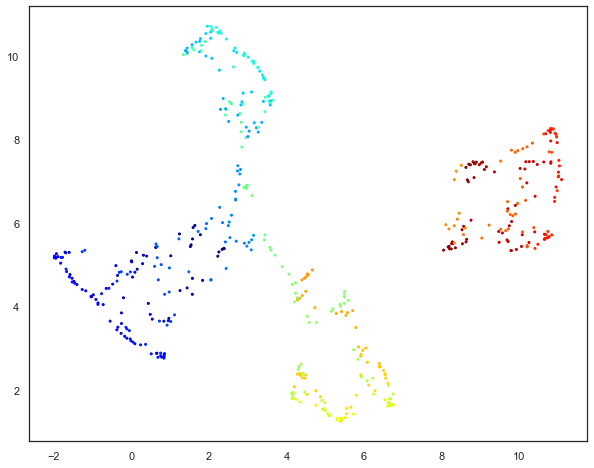

In [90]:
sns.set(style='white', rc={'figure.figsize':(10,8)})

sin_embedding = umap.UMAP(n_components=2, n_neighbors=30).fit_transform(X)
plt.scatter(sin_embedding[:, 0], sin_embedding[:, 1], c=jet_colors, s=4);

# PART 3: Using UMAP on high dimensional data for clustering
## UMAP for clustering MNIST data

Each data point is an image of 28 by 28 pixels, each pixel has an integer value between 0 and 255.

$28 \times 28 = 784$, so the dimensionality of the data is 784.

MNIST data has 70000 data points of dimensionality 784


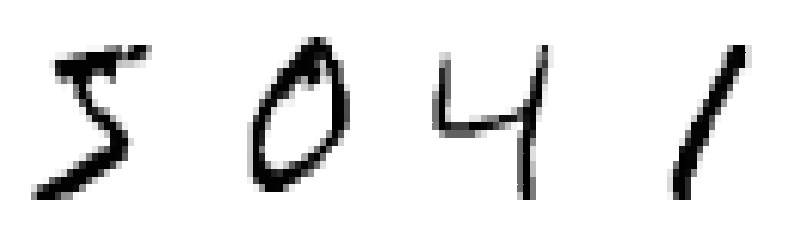

In [80]:
from sklearn.decomposition import PCA
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score

mnist = sklearn.datasets.fetch_openml('mnist_784')
mnist.target = mnist.target.astype(int)

print(f'MNIST data has {mnist.data.shape[0]} data points of dimensionality {mnist.data.shape[1]}')

fig, axs = plt.subplots(1,4, figsize=(14, 4))
for i, digit in enumerate(mnist.data[:4]):
    fig.sca(axs[i])
    sns.heatmap(digit.reshape((28,28)), cbar=False, cmap="Greys")
    axs[i].axes.get_xaxis().set_visible(False)
    axs[i].axes.get_yaxis().set_visible(False)
plt.show()

## First we create an embedding using UMAP to plot the clusters of data

This embedding will take the data from being 784 dimensional down to only 2 dimensions, so that we can plot the data. In the plot, each color represents a different digit classification.

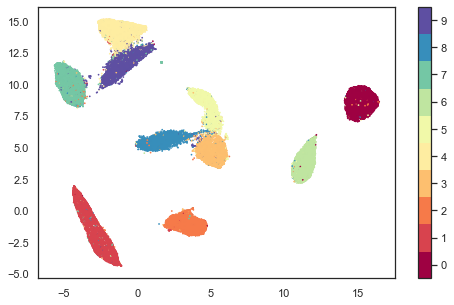

In [81]:
umap_embedding = umap.UMAP(
    n_neighbors=20,
    n_components=2,
    min_dist=0.001 # NB I have not discussed this parameter yet!
).fit_transform(mnist.data)

fig = plt.figure(figsize=(8,5))
plt.scatter(umap_embedding[:, 0], umap_embedding[:, 1], c=mnist.target.astype(int), s=0.5, cmap='Spectral')
cbar = plt.colorbar(boundaries=np.arange(11)-0.5)
cbar.set_ticks(np.arange(10))
plt.show()

## Clustering using $k$-means directly on the high dimensional data

Here we use $k$-means from scikit-learn (which we imported earlier) directly on the high dimensional data, and find that... it fails! We see that the labels are all mixed up, totally unlike the original labels.

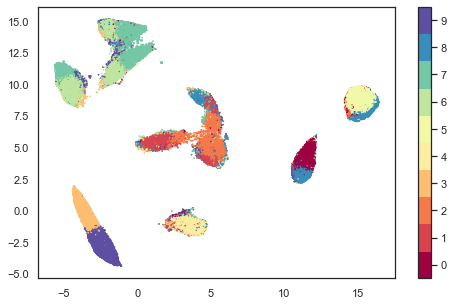

In [82]:
kmeans_labels = KMeans(n_clusters=10).fit_predict(mnist.data)

fig = plt.figure(figsize=(8,5))
plt.scatter(umap_embedding[:, 0], umap_embedding[:, 1], c=kmeans_labels, s=0.5, cmap='Spectral');
cbar = plt.colorbar(boundaries=np.arange(11)-0.5)
cbar.set_ticks(np.arange(10))
plt.show()

In [83]:
print(f'Adjusted rand score: {adjusted_rand_score(mnist.target, kmeans_labels)}')
print(f'Adjusted mutual info: {adjusted_mutual_info_score(mnist.target, kmeans_labels)}')

Adjusted rand score: 0.36523930151098133
Adjusted mutual info: 0.4996170014369887


## Clustering using $k$-means directly on the UMAP embedded data

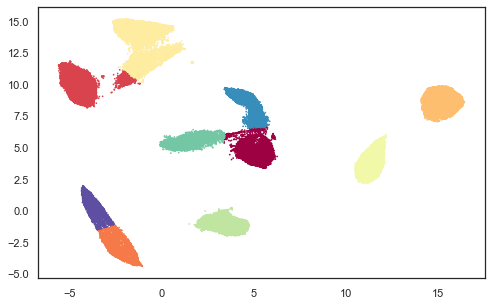

In [84]:
kmeans_labels = KMeans(n_clusters=10).fit_predict(umap_embedding)

fig = plt.figure(figsize=(8,5))
plt.scatter(umap_embedding[:, 0], umap_embedding[:, 1], c=kmeans_labels, s=0.5, cmap='Spectral');
plt.show()

In [85]:
print(f'Adjusted rand score: {adjusted_rand_score(mnist.target, kmeans_labels)}')
print(f'Adjusted mutual info: {adjusted_mutual_info_score(mnist.target, kmeans_labels)}')

Adjusted rand score: 0.7822889858839739
Adjusted mutual info: 0.8521428996986922


## Let's try a more advanced clustering technique: HBDSCAN

In [ ]:
hdbscan_labels = hdbscan.HDBSCAN(min_samples=10, min_cluster_size=500).fit_predict(mnist.data)

fig = plt.figure(figsize=(8,5))
clustered = (hdbscan_labels >= 0)
plt.scatter(umap_embedding[~clustered, 0],
            umap_embedding[~clustered, 1],
            c=(0.5, 0.5, 0.5),
            s=0.1,
            alpha=0.5)
plt.scatter(umap_embedding[clustered, 0],
            umap_embedding[clustered, 1],
            c=hdbscan_labels[clustered],
            s=0.1,
            cmap='Spectral');

In [ ]:
hdbscan_labels = hdbscan.HDBSCAN(min_samples=10, min_cluster_size=500).fit_predict(umap_embedding)

fig = plt.figure(figsize=(8,5))
clustered = (hdbscan_labels >= 0)
plt.scatter(umap_embedding[~clustered, 0],
            umap_embedding[~clustered, 1],
            c=(0.5, 0.5, 0.5),
            s=0.1,
            alpha=0.5)
plt.scatter(umap_embedding[clustered, 0],
            umap_embedding[clustered, 1],
            c=hdbscan_labels[clustered],
            s=0.1,
            cmap='Spectral');

In [87]:
print(f'Adjusted rand score: {adjusted_rand_score(mnist.target, hdbscan_labels)}')
print(f'Adjusted mutual info: {adjusted_mutual_info_score(mnist.target, hdbscan_labels)}')

Adjusted rand score: 0.9297637432237931
Adjusted mutual info: 0.9143266852594528


# Conclusion: what we have learned today

1. ### High dimensional data points are difficult to distinguish for mathematical reasons
2. ### Clustering (of just about any flavour) fails in high dimensional settings for these mathematical reasons
3. ### Data often approximately lives on a low dimensional manifold in ambient space
4. ### UMAP is a tool to _detect_ that manifold _and_ map the data from the ambient space to a _lower dimensional embedding_.
5. ### Clustering on the lower dimensional embedded data can perform extremely well.

# Issues and limitations of UMAP
 
 - Unlike classical methods of regression or PCA analysis, UMAP has relatively few tools to determine statistical success. How do we determine goodness-of-fit of a UMAP embedding? There is not much literature on this.
 
 - The embedding created by UMAP is a "black box". There is no simple analytical understanding of what UMAP has actually done to the data.
 
 - The underlying assumption of UMAP is that **the data is uniformly distributed on the underlying manifold**. This assumption isn't necessarily true of most data sets. Perhaps it is a flawed point-of-view?
